In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/Delphine-Jean/Sources/main/conversion_data.csv?token=AGKBMYIERWUXZVR4QHLXNKC7WLQEE")

In [3]:
dataset.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


##### Data description et data cleaning

Describe and groupby are usually the best places to start:

In [4]:
dataset.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
dataset = dataset[dataset["age"] < 110]

In [6]:
dataset.groupby(["source"]).size()

source
Ads        88739
Direct     72420
Seo       155039
dtype: int64

In [7]:
dataset.groupby(["country"]).size()

country
China       76602
Germany     13055
UK          48449
US         178092
dtype: int64

#### Observations:

Le site semble être américains mais posséde beaucoup d'utilisateur situés en Chine

LLa cible est jeune. 

On observe un outlier "123" pour l'âge.

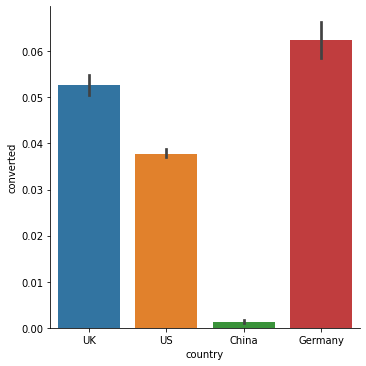

In [8]:
sns.catplot(x="country", y="converted", data=dataset, kind="bar")

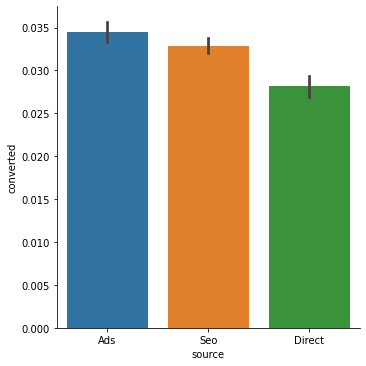

In [9]:
sns.catplot(x="source",y="converted",data=dataset, kind="bar")

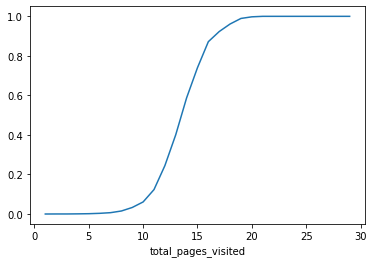

In [10]:
dataset.groupby(["total_pages_visited"])["converted"].mean().plot()

## Machine Learning

In [11]:
# Création des dummies variables sur les variables catégoriques

dataset_dummy = pd.get_dummies(dataset,drop_first=True)

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset_dummy, test_size=0.34)

In [13]:
# IMPORTATION DE RANDOM FORREST ET DE NOTRE METRIC

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [14]:
rd_clf = RandomForestClassifier(n_estimators=300, max_features=3, oob_score=True)
rd_clf.fit(train.drop("converted", axis=1), train["converted"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
#Observation du score de validation Out Of Bag utilisant la même méthode bagging
print("OOB_score is",
      rd_clf.oob_score_,
      "\n",
      "OOB Confusion Matrix",
      "\n",
      pd.DataFrame(confusion_matrix(train['converted'], rd_clf.oob_decision_function_[:,1].round(), labels=[0, 1]))
      )

OOB_score is 0.9844170779625282 
 OOB Confusion Matrix 
         0     1
0  200882  1060
1    2192  4556


### Evaluation de la précision et observation de la matrice de confusion

In [16]:
print(
"Test accuracy is", rd_clf.score(test.drop('converted', axis=1), test['converted']),
"\n",
"Test Set Confusion Matrix",
"\n",
pd.DataFrame(confusion_matrix(test['converted'],rd_clf.predict(test.drop('converted',axis=1)), labels=[0,1])))     


Test accuracy is 0.9843453510436433 
 Test Set Confusion Matrix 
         0     1
0  103525   533
1    1150  2300


### Ainsi, l'erreur OOB et l'erreur de test sont assez similaires, ~ 1,5%. Nous sommes convaincus que nous ne sommes pas surajustés.

L'erreur est assez faible. Cependant, nous sommes partis d’une précision de 97% (c’est le cas si nous classons tout comme «non converti»). Donc, 98,5%, c'est bien, mais rien de choquant. En effet, environ 30% des conversions sont prédites comme «sans conversion».

Si nous nous soucions de la meilleure précision possible ou si nous minimisons spécifiquement les faux positifs / faux négatifs, nous trouverions le meilleur point de coupure. Étant donné que dans ce cas, cela ne semble pas particulièrement pertinent, nous acceptons la valeur seuil par défaut de 0,5 utilisée en interne par la forêt aléatoire pour effectuer la prédiction.

Si vous vous souciez des informations, la création d'un modèle n'est que la première étape. Vous devez vérifier que le modèle prédit bien et, si tel est le cas, vous pouvez maintenant en extraire des informations.

Commençons par vérifier l'importance des variables:

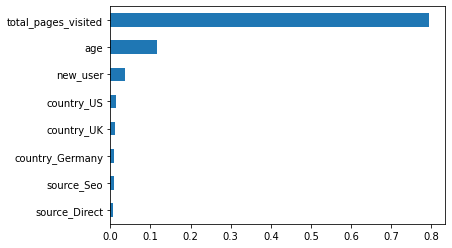

In [17]:
feat_importances = pd.Series(rd_clf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

#### Le nombre total de pages visitées est de loin le plus important. Malheureusement, c'est probablement le moins «exploitable». Les gens visitent de nombreuses pages parce qu'ils veulent déjà acheter. De plus, pour acheter, vous devez cliquer sur plusieurs pages. Reconstruisons le RF sans cette variable. Étant donné que les classes sont fortement déséquilibrées et que nous n'avons plus cette variable très puissante, changeons les poids, juste pour nous assurer que nous obtiendrons quelque chose de classé 1.

In [18]:
rd_clf = RandomForestClassifier(n_estimators=100,max_features=3,oob_score=True, class_weight={0:1,1:10})
rd_clf.fit(train.drop(['converted','total_pages_visited'], axis=1),train['converted'])

print(
    'OOB accuracy is',
    rd_clf.oob_score_,
    "/n",
    "OOB Confusion Matrix",
    "/n",
    pd.DataFrame(confusion_matrix(train["converted"],rd_clf.oob_decision_function_[:,1].round(), labels=[0,1]))
)

OOB accuracy is 0.8920839522737074 /n OOB Confusion Matrix /n         0      1
0  183226  18716
1    3805   2943


In [19]:
# Test de précision et matrice de confusion
print(
"Test accuracy is", rd_clf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rd_clf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8898128511366596 
 Test Set Confusion Matrix 
        0     1
0  94147  9911
1   1935  1515


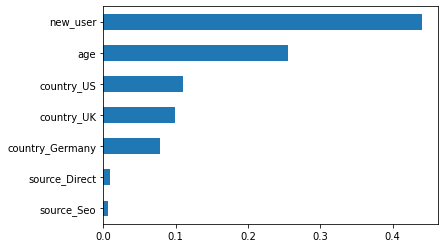

In [20]:
feat_importances = pd.Series(rd_clf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

### Le nouvel utilisateur est le plus important, encore plus important que l'âge. Et c’est impressionnant étant donné que nous savons à quel point les variables continues ont tendance à toujours apparaître en haut des graphiques d’importance des variables RF. Cela signifie que new_user est vraiment important. Les mannequins liés à la source ne semblent pas du tout avoir d'importance.

     |████████████████████████████████| 57.7MB 74kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=a2bf00d669aa72bc53a292a458ffbdb10d7aac1a554fe53afd43cb6a9ad6aca8
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


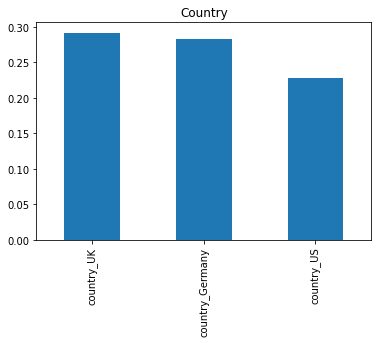

In [21]:
!pip install pdpbox
from pdpbox import pdp, info_plots

#country
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()


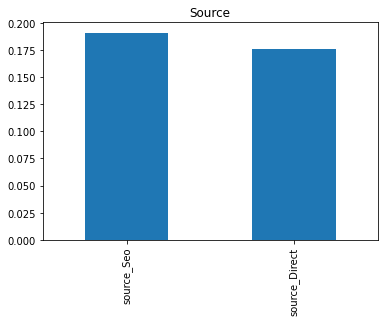

In [22]:
#source
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

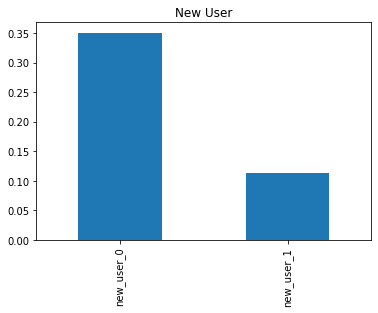

In [23]:
#new user
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()


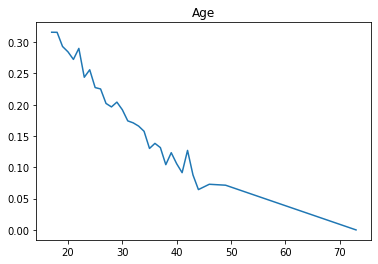

In [24]:
#age
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

### Cela montre que:

Les utilisateurs avec un ancien compte sont bien meilleurs que les nouveaux utilisateurs

L'Allemagne, le Royaume-Uni et les États-Unis sont similaires, l'Allemagne étant la meilleure. Plus important encore, ils ont tous des valeurs très très élevées. Comme d'habitude, nous devons lire cela par rapport au niveau de référence, qui est la Chine. Cela signifie donc que ne pas être de Chine et être de l'un de ces 3 pays augmente considérablement la probabilité de conversion. Autrement dit, la Chine est très mauvaise pour la conversion

Le site fonctionne très bien pour les jeunes et empire pour les personnes âgées

La source est moins pertinente

Créons maintenant un arbre de décision simple et vérifions les 2 ou 3 segments les plus importants:

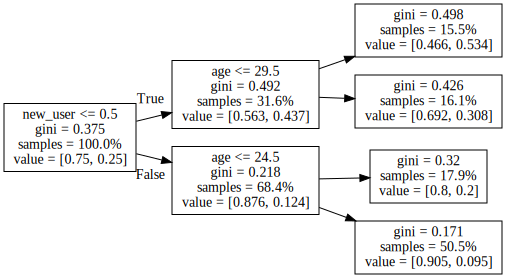

In [25]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#visualize it
dot_data = export_graphviz(tree, out_file=None, feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
graph = graphviz.Source(dot_data)

graph